In [44]:
import pathlib
from pedpy.io.trajectory_loader import load_trajectory
from pedpy.data.geometry import MeasurementLine, WalkableArea
from pedpy.methods.method_utils import compute_individual_voronoi_polygons, Cutoff

import matplotlib.pyplot as plt
from pedpy.plotting.plotting import plot_measurement_setup
from pedpy.methods.flow_calculator import separate_species, calc_speed_on_line, calc_density_on_line, calc_flow_on_line
from pedpy.methods.speed_calculator import compute_individual_speed

In [45]:
pedpy_blue = (89 / 255, 178 / 255, 216 / 255)
pedpy_orange = (220 / 255, 160 / 255, 73 / 255)
pedpy_green = (108 / 255, 190 / 255, 167 / 255)
pedpy_petrol = (98 / 255, 190 / 255, 190 / 255)
pedpy_grey = (114 / 255, 125 / 255, 139 / 255)
pedpy_red = (233 / 255, 117 / 255, 134 / 255)

In [46]:
from pedpy.io.trajectory_loader import TrajectoryUnit

traj_paths = ("bi_corr_400_b_08.txt", "040_c_56_h-.txt", "bi_corr_400_b_03.txt", "traj_UNI_CORR_500_08.txt")
selected_traj = traj_paths[0]


if selected_traj == traj_paths[0]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-6.0, 0),
            (5, 0),
            (5, 4),
            (-6, 4)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
elif selected_traj == traj_paths[1]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    obstacles=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier
        [
            (0.25, -1.1),
            (0.7, -1.1),
            (0.7, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.4, 0.0),
            (0.25, -0.15),
            (0.25, -1.1),
        ],
    ],)
    
    measurement_line = MeasurementLine([(0.25, 0), (-0.25, 0)])
elif selected_traj == traj_paths[2]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-6.0, -0.5),
            (5, 0),
            (5, 4),
            (-6, 4.5)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 4.0)])
elif selected_traj == traj_paths[3]:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj), default_unit=TrajectoryUnit.METER
    )
    walkable_area = WalkableArea(
        # complete area
        [
            (-5.5, 0),
            (5, 0),
            (5, 5),
            (-5.5, 5)
        ])
    measurement_line = MeasurementLine([(0.0, 0.0), (0.0, 5.5)])

else:
    traj = load_trajectory(
        trajectory_file=pathlib.Path(selected_traj)
    )
    raise f"for the selected traj is no walkable area defined"

In [47]:
individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj,
    walkable_area=walkable_area,
    cut_off=Cutoff(radius=0.8, quad_segments=3),
)

In [48]:
individual_speed = compute_individual_speed(
    traj_data=traj,
    frame_step=1,
    compute_velocity=True,
)

In [49]:
species = separate_species(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, individual_speed=individual_speed)

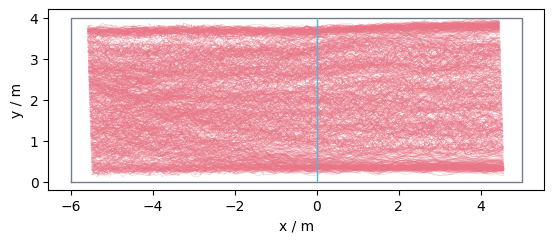

In [50]:
plot_measurement_setup(
    traj=traj,
    walkable_area=walkable_area,
    traj_alpha=0.5,
    traj_width=0.3,
    measurement_lines=[measurement_line],
    ma_line_width=2,
    ma_alpha=0.5,
).set_aspect("equal")

plt.show()

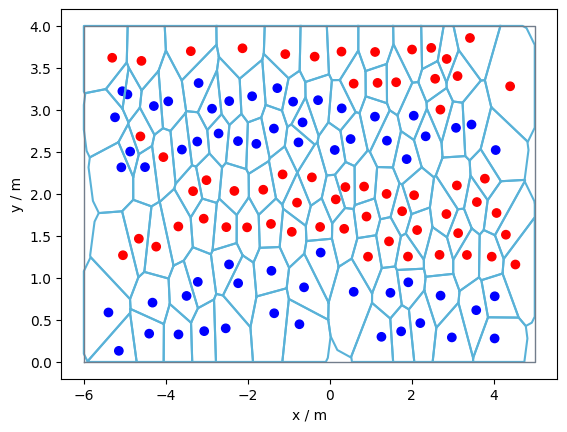

In [51]:
from pedpy.plotting.plotting import plot_voronoi_cells
import numpy as np

frame = 500

plot_voronoi_cells(voronoi_data=individual_cutoff, frame=frame, traj_data=traj, walkable_area=walkable_area)
positions = traj.data.merge(species[['id', 'species']], on='id', how='left') 

positions['color'] = np.where(positions['species'] == 1, "b", "r")
idx = positions["frame"] == frame
plt.scatter(positions[idx]["x"], positions[idx]["y"], c=positions[idx]["color"])
plt.show()

In [52]:
default_linewidth = 0.5
def plot_speed_at_line(speed_on_line, line_width=default_linewidth):
    plt.plot(speed_on_line['frame'], speed_on_line['v_sp+1'], label='species 1', linewidth=line_width) 
    plt.plot(speed_on_line['frame'], speed_on_line['v_sp-1'], label='species 2', linewidth=line_width)
    plt.plot(speed_on_line['frame'], speed_on_line['v_total'], label='total', linewidth=line_width)
    plt.xlabel('frame')
    plt.ylabel('velocity on line')
    plt.legend()

def plot_density_at_line(density_on_line, line_width=default_linewidth):
    plt.plot(density_on_line['frame'], density_on_line['p_sp+1'], label='species 1', linewidth=line_width) 
    plt.plot(density_on_line['frame'], density_on_line['p_sp-1'], label='species 2', linewidth=line_width)
    plt.plot(density_on_line['frame'], density_on_line['p_total'], label='total', linewidth=line_width)
    plt.xlabel('frame')
    plt.ylabel('density on line')
    plt.legend()
    
def plot_flow_at_line(flow_on_line, line_width=default_linewidth):
    plt.plot(flow_on_line['frame'], flow_on_line['j_sp+1'], label='species 1', linewidth=line_width) 
    plt.plot(flow_on_line['frame'], flow_on_line['j_sp-1'], label='species 2', linewidth=line_width)
    plt.plot(flow_on_line['frame'], flow_on_line['j_total'], label='total', linewidth=line_width)
    plt.xlabel('frame')
    plt.ylabel('flow on line')
    plt.legend()

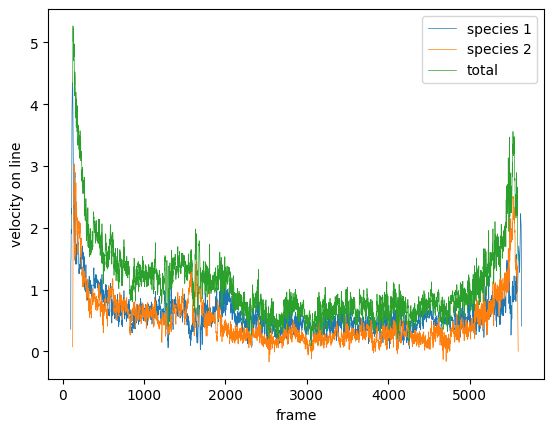

In [53]:
plot_speed_at_line(calc_speed_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, individual_speed=individual_speed, species=species))
plt.show()

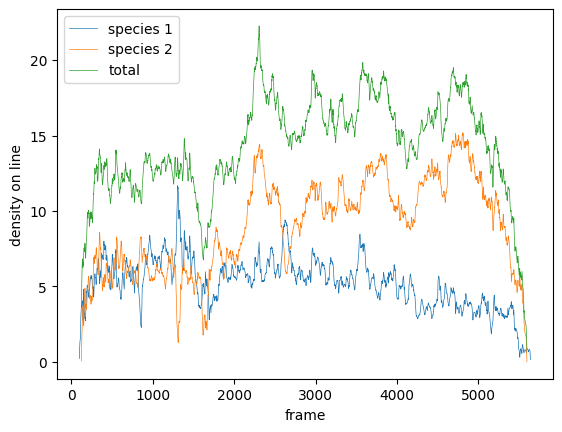

In [54]:
plot_density_at_line(calc_density_on_line(individual_voronoi_polygons=individual_cutoff, measurement_line=measurement_line, species=species))
plt.show()

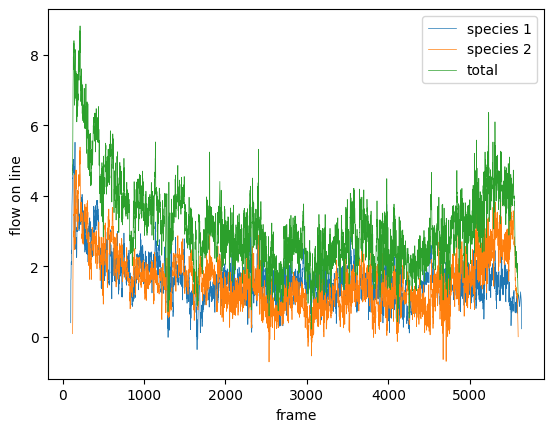

In [55]:
plot_flow_at_line(calc_flow_on_line(individual_voronoi_polygons=individual_cutoff,measurement_line=measurement_line, individual_speed=individual_speed, species=species))
plt.show()